In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d catherinehorng/dogbreedidfromcomp

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 684M/691M [00:04<00:00, 170MB/s]
100% 691M/691M [00:04<00:00, 149MB/s]


In [ ]:
!unzip dogbreedidfromcomp.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [ ]:
# Importing library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [ ]:
# Read the labels.csv file and check shape and records
labels_all = pd.read_csv('labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Loading number or each breed
breed_all = labels_all['breed']
breed_count = breed_all.value_counts()
breed_count.head()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

In [ ]:
# Selecting all breeds because we have high computation power
CLASS_NAME = ['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAME))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


In [ ]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAME)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 588/588 [00:02<00:00, 243.91it/s]


Train Images shape:  (588, 224, 224, 3)  size: 88,510,464
One-hot encoded output shape:  (588, 5)  size: 2,940


In [ ]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size=0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size=0.2)

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Use VGG16 pre-trained model + additional custom layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CLASS_NAME), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Compile the model with a different optimizer and learning rate
model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Add data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Use early stopping and learning rate reduction on plateau
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
]

In [ ]:
# Train the model
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, Y_val),
                    callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 12s 3s/step - loss: 2.2882 - accuracy: 0.2057 - val_loss: 1.5640 - val_accuracy: 0.2642 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 8s 2s/step - loss: 1.8433 - accuracy: 0.2459 - val_loss: 1.4689 - val_accuracy: 0.3396 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - 11s 3s/step - loss: 1.6364 - accuracy: 0.2884 - val_loss: 1.4862 - val_accuracy: 0.3774 - lr: 1.0000e-04
Epoch 4/100
4/4 [==============================] - 8s 2s/step - loss: 1.5595 - accuracy: 0.3428 - val_loss: 1.3698 - val_accuracy: 0.4906 - lr: 1.0000e-04
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 1.5040 - accuracy: 0.3499 - val_loss: 1.3536 - val_accuracy: 0.4811 - lr: 1.0000e-04
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 1.4934 - accuracy: 0.3546 - val_loss: 1.3085 - val_accuracy: 0.4906 - lr: 1.0000e-04
Epoch 7/100
4/4 [==============================] - 8s 2s/step - loss

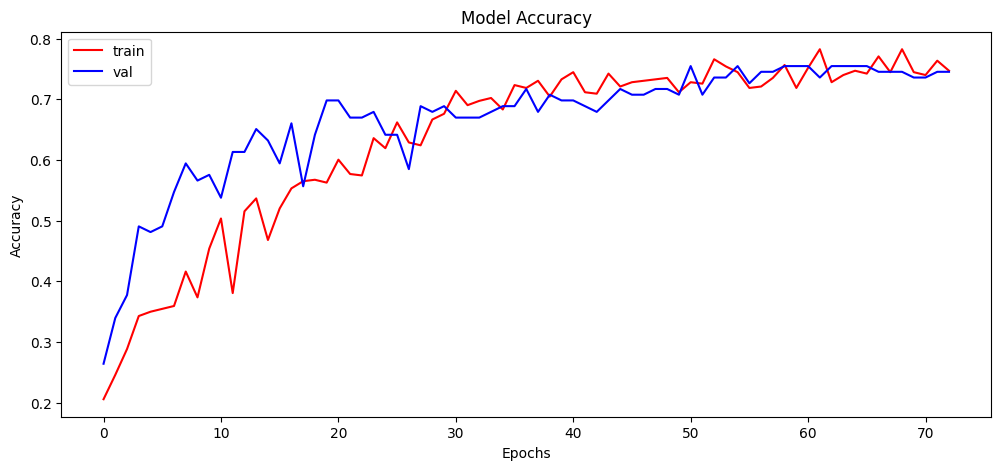

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Evaluating the model on the test set
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: ', round((score[1] * 100), 2), '%')

2/2 [==============================] - 0s 119ms/step - loss: 0.5758 - accuracy: 0.7797
Accuracy over the test set:  77.97 %


2/2 [==============================] - 0s 152ms/step


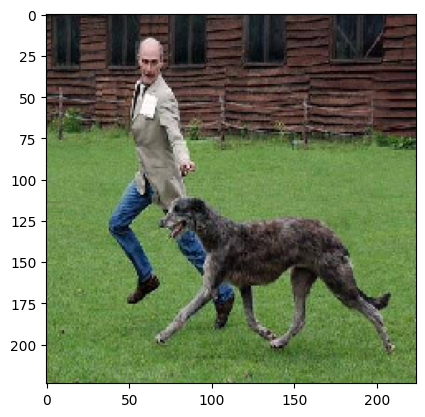

Original breed:  scottish_deerhound
Predicted breed:  scottish_deerhound


In [ ]:
# Making predictions on the test set
Y_pred = model.predict(X_test)

# Plotting an image from the test set and comparing the original vs predicted breed
plt.imshow(X_test[1])
plt.show()

# Getting the index of the maximum predicted probability
predicted_index = np.argmax(Y_pred[1])
true_index = np.argmax(Y_test[1])

# Printing the results
print("Original breed: ", CLASS_NAME[true_index])
print("Predicted breed: ", CLASS_NAME[predicted_index])